## Normalization, Feature, Selection, and Dimension reduction (w1118_42D)

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scvi
from scipy.sparse import csr_matrix
from scipy.stats import median_abs_deviation
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import anndata2ri
import logging
import matplotlib.pyplot as plt

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sns.set_style('white')
sns.set(font_scale=1.5)
sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()
sc.settings.verbosity = 3

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


/scratch/5353760.1.kolaczyk-pub/ipykernel_35654/2032537699.py:26: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
## Set up I/O directories
basepath = Path("/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/")
inputpath = basepath.joinpath('analysis','preprocess')
outputpath = basepath.joinpath('analysis','preprocess')
outputfile = basepath.joinpath('analysis','preprocess','w1118_42D.h5ad')

w1118_42d = sc.read_h5ad(inputpath.joinpath("w1118_42D.h5ad"))


w1118_42d

AnnData object with n_obs × n_vars = 8200 × 11652
    obs: 'cell_barcode', 'column_name', 'sample', 'sum', 'detected', 'percent.top_50', 'percent.top_100', 'percent.top_200', 'percent.top_500', 'total', 'doubletFinder_doublet_score_resolution_1.5', 'doubletFinder_doublet_label_resolution_1.5', 'scds_cxds_score', 'scds_cxds_call', 'scds_bcds_score', 'scds_bcds_call', 'scds_hybrid_score', 'scds_hybrid_call', 'decontX_contamination', 'decontX_clusters', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'outlier', 'mt_outlier'
    var: 'feature_ID', 'feature_name', 'feature_type', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'log1p_mean_counts', 'log1p_total_counts'
    uns: 'X_name', 'assayType', 'runBcds', 'runCxds', 'runCxdsBcdsHybrid', 'runDoubletFinder', 'scater', 'scater_addPerCellQC', 'sctk'
    obs

## Normalization

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


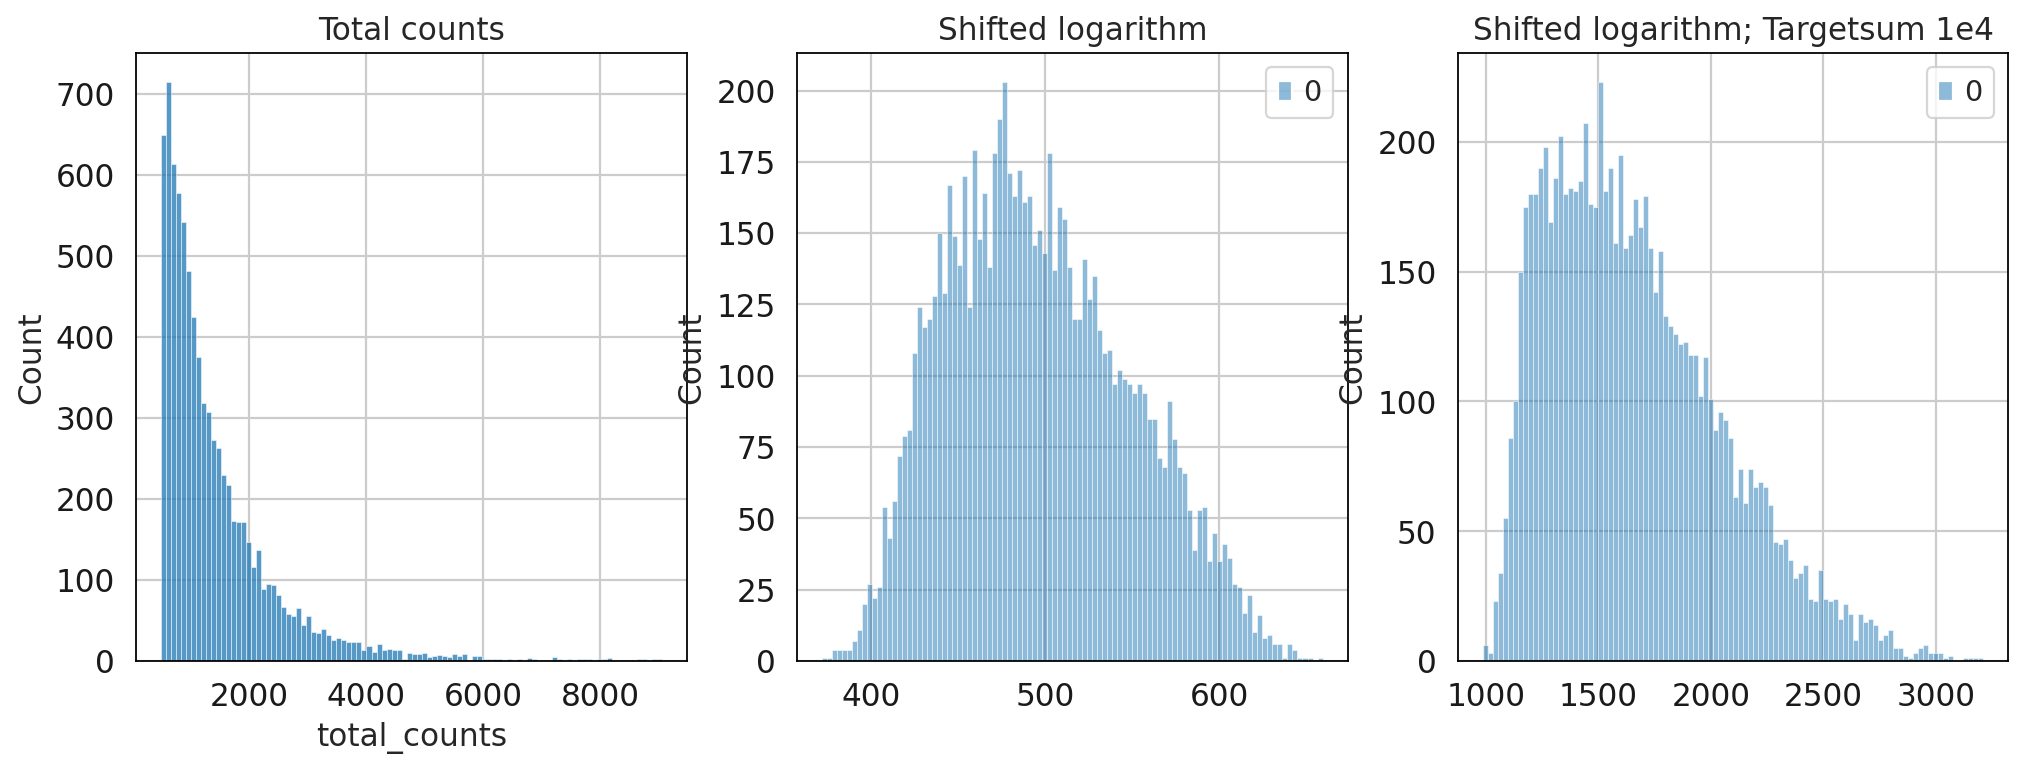

In [3]:
scales_counts = sc.pp.normalize_total(w1118_42d, target_sum=None, inplace=False)
scales_counts_1e4 = sc.pp.normalize_total(w1118_42d, target_sum=1e4, inplace=False)


w1118_42d.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
w1118_42d.layers["log1p_norm_1e4"] = sc.pp.log1p(scales_counts_1e4["X"], copy=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
p1 = sns.histplot(w1118_42d.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(w1118_42d.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
p2 = sns.histplot(w1118_42d.layers["log1p_norm_1e4"].sum(1), bins=100, kde=False, ax=axes[2])
axes[2].set_title("Shifted logarithm; Targetsum 1e4")
plt.show()

## Feature Selection

In [4]:
%%R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("scry")
#library("scry")

ValueError: Not an rpy2 R object and unable to map it to one: 'value'

In [ ]:

sc.pp.highly_variable_genes(w1118_42d, layer="log1p_norm")
with plt.rc_context({"figure.figsize": (6, 6), "figure.dpi": (60)}):
    sc.pl.highly_variable_genes(w1118_42d)


In [ ]:


sc.pp.highly_variable_genes(w1118_42d, min_mean=0.0125, max_mean=3, min_disp=0.5)
with plt.rc_context({"figure.figsize": (6, 6), "figure.dpi": (60)}):
    sc.pl.highly_variable_genes(w1118_42d)
w1118_42d.raw = w1118_42d
w1118_42d.write(outputfile)
sc.tl.pca(w1118_42d, svd_solver="arpack")
fig,ax= plt.subplots(1,3,figsize=(13,4))
sc.pl.pca(w1118_42d, color="elav",show=False,ax=ax[0])
sc.pl.pca(w1118_42d, color="repo",show=False,ax=ax[1])
sc.pl.pca(w1118_42d, color="drpr",show=False,ax=ax[2])
sc.pl.pca_variance_ratio(w1118_42d, log=True)
w1118_42d.write(outputfile)
sc.pp.neighbors(w1118_42d, n_neighbors=50, n_pcs=30)
sc.tl.leiden(
    w1118_42d,
    resolution=0.2,
    random_state=1,
    n_iterations=20,
    directed=False,
)

sc.tl.paga(w1118_42d)
sc.pl.paga(w1118_42d, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(w1118_42d, init_pos='paga')

sc.pl.umap(w1118_42d, color=["leiden",
                            "elav", "lncRNA:noe","VAChT", "VGlut","Gad1","Vmat", ##neurons
                             "repo", "lncRNA:CR34335","alrm","wrapper","Indy","moody", ##glia 
                             "ninaC","trp","trpl", ## photoreceptors
                             "Hml","ppl","drpr"], size=23)


sc.tl.rank_genes_groups(w1118_42d, "leiden", method="t-test")
sc.pl.rank_genes_groups(w1118_42d, n_genes=25, sharey=False)

sc.tl.rank_genes_groups(w1118_42d, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(w1118_42d, n_genes=25, sharey=False)

sc.tl.rank_genes_groups(w1118_42d, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(w1118_42d, n_genes=25, sharey=False)
